$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$

<div align=center>

### Open me with [Google Colab](https://colab.research.google.com/) for a better experience!
Also, collapse all the code cells to have a clear view of the notebook.

</div>

$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

---
# Initialization

In [1]:
# Check, install and import requirements and define utility functions.
#@title ###### Check, install and import requirements and define utility functions.

import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
import os
import time

dependencies = [
  'numpy',
  'matplotlib'
]

try:
    pkg_resources.require(dependencies)
except DistributionNotFound:
    os.system("pip install numpy")
    os.system("pip install matplotlib")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from copy import deepcopy
from IPython.display import display as disp, Math, Latex

def as_latex_matrix(m, replace_zeros = "0", round=3, max_size=8):
  """Convert a matrix to a LaTeX matrix stored as a string."""
  m = np.array(m)

  Hcut = m.shape[0] > max_size
  Vcut = m.shape[1] > max_size
  if Hcut or Vcut:
    cut_at = int(np.ceil(max_size/2))
    a = np.empty(
      (min(m.shape[0], max_size), min(m.shape[1], max_size)), dtype=complex
    )

    if Hcut and Vcut:
      a[:cut_at, :cut_at] = m[:cut_at, :cut_at]
      a[:cut_at, -cut_at:] = m[:cut_at, -cut_at:]
      a[-cut_at:, :cut_at] = m[-cut_at:, :cut_at]
      a[-cut_at:, -cut_at:] = m[-cut_at:, -cut_at:]
    elif Hcut and not Vcut:
      a[:cut_at, :] = m[:cut_at, :]
      a[-cut_at:, :] = m[-cut_at:, :]
    elif Vcut and not Hcut:
      a[:, :cut_at] = m[:, :cut_at]
      a[:, -cut_at:] = m[:, -cut_at:]
    
    m = a

  def matrix_line(line, replace_zeros):
    line_elements = []
    for i, element in enumerate(line):
      if Hcut and i == cut_at:
        line_elements.append(r"\cdots")
      if (i := np.round(element, round)) != 0 or not replace_zeros:
        if np.imag(i) == 0:
          i = np.real(i)
        if int(i) == i:
          i = int(i)
        line_elements.append(f"{i}")
      else:
        line_elements.append(str(replace_zeros))
    return " & ".join(line_elements)

  if len(m.shape) == 1:
    matrix = matrix_line(m, replace_zeros)
  else:
    matrix = []
    for i, line in enumerate(m):
      if Vcut and i == cut_at:
        matrix.append("&".join([r"\cdots"]*(m.shape[1]+1)))
      matrix.append(matrix_line(line, replace_zeros))   
    
    matrix = r"\\ ".join(matrix)
  
  return r"\begin{pmatrix}" + matrix + r"\end{pmatrix}"

def braket_notation(vector, separator="", round=3):
  """Convert a vector to a LaTeX ket notation."""
  vector = np.array(vector)
  vector = np.round(vector,round)

  N = vector.shape[0]
  n = int(np.sqrt(N))
  
  if vector.shape[0] == 1:
    vec = vector[0,:]
    state='';
    for i in range(N):
        if abs(vec[i])>10**(-6):
            state=state+'+'+str(vec[i])+r' \bra{'+format(i,'0'+str(n)+'b')+r'} '
  else:
    vec = vector[:,0]
    state='';
    for i in range(N):
        if abs(vec[i])>10**(-6):
            state=state+'+'+str(vec[i])+r' \ket{'+format(i,'0'+str(n)+'b')+r'} '
  return state

def scalar(m):
  """Convert a 1x1 matrix to a scalar."""
  return m.item()

def print_latex(code):
  """Print a LaTeX string."""
  disp(Math(code))

def as_array(vec):
  """Convert a vector to a numpy array."""
  return np.array(vec).reshape(max(vec.shape))

In [2]:
# Include base code (given in subject)
#@title ###### Include base code (given in subject)

import numpy as np
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as LA;
from scipy import linalg as LA2;
from numpy import random as rand
from scipy.sparse import diags

def tensorvect(a,b):
    return(np.tensordot(a,b,axes=0).flatten())

def tensorvectop(a,b):
    return LA2.kron(a,b)

def opchain(a,i,nspin):
    if i==1:
        return LA2.kron(a,np.identity(2**(nspin-1)))
    else:
        if i==nspin:
            return LA2.kron(np.identity(2**(nspin-1)),a)
        else:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
        
def opchain2(a,i,b,j,nspin):
    if i==1:
        if j==nspin:
            return LA2.kron(LA2.kron(a,np.identity(2**(nspin-2))),b)
        else:
            return LA2.kron(LA2.kron(a,np.identity(2**(j-2))),LA2.kron(b,np.identity(2**(nspin-j))))      
    else:
        if j==nspin:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(nspin-(i+1))),b))
        else:
            return LA2.kron(LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))
            
def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)


def diracrep(psi,nspin):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-6):
            state=state+'+'+str(psi[i])+'|'+format(i,'0'+str(nspin)+'b')+'>'
    return state

def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]
    
def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(tr)

def SvN(rho):
    vp=np.real(LA.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)

sigX=np.array([[0.,1.],[1.,0.]]);
sigY=np.array([[0.,-1j],[1j,0.]]);
sigZ=np.array([[1.,0.],[0.,-1.]]);
sig1=np.array([[1.,0.],[0.,0.]]);
id2 =np.array([[1.,0.],[0.,1.]]);

NOT=sigX;
HAD1=np.array([[1./np.sqrt(2.),1./np.sqrt(2.)],[1./np.sqrt(2.),-1./np.sqrt(2.)]]);
CNOT=np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.],[0.,0.,1.,0.]]);
HAD2=np.array([[0.5,0.5,0.5,0.5],[0.5,-0.5,0.5,-0.5],[0.5,0.5,-0.5,-0.5],[0.5,-0.5,-0.5,0.5]]);
SWAP=np.array([[1.,0.,0.,0.],[0.,0.,1.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.]]);

---
# Chapter 1

### Constants
We set
$$
\hbar = 1
$$

In [3]:
# Defining constants

hbar = 1

### Pauli matrices
We know the Pauli matrices:

$$
\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$

$$
\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}
$$

$$
\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [4]:
# Definition of pauli matrices
#@title ###### Definition of pauli matrices

sigma = [
    np.matrix(
        [[0, 1],
         [1, 0]]
    ),

    np.matrix(
        [[0, -1j],
         [1j,  0]]
    ),
    
    np.matrix(
        [[1,  0],
        [0, -1]]
    )
]

### Spins
We can deduce the spin matrices

$$
S_x = \frac \hbar 2 \sigma_x = \ket 0 \bra 1 + \ket 1 \bra 0    
$$

$$
S_y = \frac \hbar 2 \sigma_y = \ket 0 \bra 1 - \ket 1 \bra 0
$$

$$
S_z = \frac \hbar 2 \sigma_z = \ket 0 \bra 0 - \ket 1 \bra 1
$$

In [5]:
# Definition of the spin matrices
#@title ###### Definition of the spin matrices

S = [hbar/2 * sigma[i] for i in range(3)]

#print(S[0], "\n\n", S[1], "\n\n", S[2])

### $h_0$
And then, $h_0$ is defined such as:
$$
h_0 = - \gamma B S_z =
\begin{pmatrix}
\frac \omega 2 & ... & 0 \\
... & \searrow & ... \\
0 & ... & \frac \omega 2
\end{pmatrix}
$$

$$
\rightarrow h_0 = \begin{pmatrix} -\omega & 0 \\ 0 & 0 \end{pmatrix} D
$$

In [6]:
# Definition of h_0 and I
#@title ###### Definition of $h_0$ and $I$

def get_h0(w):
    return np.matrix([
        [-w, 0],
        [ 0, 0]
    ])

def get_I(N):
    return np.matrix(np.eye(N))

### Hamiltonian
If we consider a system with several spins, the total hamiltonian is the sum of the hamiltonians of each spin and the interaction between them.

For exemple, in the case of 2 spins:

$$
H_T = H_1 + H_2 + H_{12} = H_0 + H_{int}
$$

Where

$$
H_1 = h_0 \otimes I_z = \begin{pmatrix} -\omega & 0 \\ 0 & 0 \end{pmatrix} \otimes \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} = \begin{pmatrix} -\omega & 0 & 0 & 0 \\ 0 & -\omega & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix}
$$

$$
H_2 = I_2 \otimes h_0 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \otimes \begin{pmatrix} -\omega & 0 \\ 0 & 0 \end{pmatrix} = \begin{pmatrix} -\omega & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & -\omega & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix}
$$

And $H_{12}$ is defined such as:
$$
\begin{array}{rl}
H_{int} &= - \sum_{i=1}^N \sum_{j>i} \vec J_{ij} \vec S_i \odot \vec S_j\\
&= - \sum_{i=1}^N \sum_{j>i} \sum_{u \in {x,y,z}} \vec J_{ij}^u \vec S_i^u\vec S_j^u\\
\end{array}
$$

In [7]:
# Definition of H_int
#@title ###### Definition of H_int

def get_H_int(J, S, verbose = False):

    # Getting the number of spins
    _, N, _ = J.shape

    # Initalizing the Hamiltonian with a matrixc of size*size filled of 0
    H = np.matrix(np.zeros((2**N, 2**N), dtype=complex))

    # Sums
    for i in range(1,N): # 1 to N-1
        for j in range(i+1, N+1): # i+1 to N
            for u in range(3): # 0 to 2
                H -= J[u,i-1,j-1] * opchain2(S[u], i, S[u], j, N) # cf. eq 1.6

                # Debug
                if verbose:
                    print("\n------------------------------\n")
                    print("i j u J[u,i,j]")
                    print(i,j, ["x","y","z"][u], J[u,i,j])
                    print(" ")
                    print(J[u,i,j] * opchain2(S[u], i+1, S[u], j+1, N).astype(float))
    
    return H

### Models

$$
\forall i,j,u \in \{1,...,N\} \quad \text{and} \quad \forall u \in \{x,y,z\}
$$



<div align=center>

#### Ferromagnetic

$$
J_{ij, closed}^u \begin{cases}
    \geq 0 & \text{if } j = i+1\\
    = 0 & \text{otherwise}
\end{cases}
$$

#### Antiferromagnetic

$$
J_{ij, closed}^u \begin{cases}
    \leq 0 & \text{if } j = i+1\\
    = 0 & \text{otherwise}
\end{cases}
$$

#### Open Ising model

$$
J_{ij, open}^u = \begin{cases}
    J\delta_{i,j+1} & \text{if } u = z\\
    0 & \text{if } u = \{x,y\} \end{cases}
$$

#### Closed Ising model

$$
J_{ij, closed}^u = \begin{cases}
    J\delta_{i,j+1} + J\delta_{i,1}\delta_{j,N} & \text{if } u = z\\
    0 & \text{otherwise}\end{cases}  
$$

#### Heisenberg XXX

$$
J_{i,j}^u = J_x \delta_{i,j+1}
$$

#### Heisenberg XXZ

$$
\forall i,j \in \{1,...,N\} \quad J_{i,j}^u = \begin{cases}
    J_x\delta_{i,j+1} & \text{if } u \in \{x,y\}\\
    J_z\delta_{i,j+1} & \text{if } u = z
\end{cases}
$$

#### Heisenberg XYZ

$$
\forall i,j \in \{1,...,N\} \quad J_{i,j}^u = \begin{cases}
    J_x\delta_{i,j+1} & \text{if } u = x\\
    J_y\delta_{i,j+1} & \text{if } u = y\\
    J_z\delta_{i,j+1} & \text{if } u = z
\end{cases}
$$

</div>

In [8]:
# Model class

def openSpinChain(sig, N=8, omega=0.5, J=1):
        h_0 = -omega * sig1
        H_0 = sum([opchain(h_0, i, N) for i in range(1, N + 1)])
        H_int = np.zeros(H_0.shape, dtype=complex)
        for i in range(N - 1):
            H_int -= J * opchain2(.5 * sig, i + 1, .5 * sig, i + 2, N)
        return H_0, H_int, H_0 + H_int

def closedSpinChain(sig, N=8, omega=0.5, J=1):
    H = openSpinChain(sig, N, omega, J)
    H -= J * opchain2(.5 * sig, 1, .5 * sig, N, N)
    return H

class Model:

    def __init__(self, name, model, N=8, w=0.5, J=1, closed = False):
        self.name = name
        self.N = N
        self.w = w
        if isinstance(J, int) or isinstance(J, float):
            self.J = np.ones(3)*J
        else:
            self.J = np.array(J)
        self.J_matrix = model(N = N, J = J, closed = closed)
        self.update_H()

    def update_H(self):
        H0_LIST = [opchain(get_h0(self.w), i+1, self.N) for i in range(self.N)]
        self.H0 = np.matrix(np.sum(H0_LIST, axis=0))

        self.Hi = get_H_int(self.J_matrix, S)

        self.H = self.H0 + self.Hi

    # ========== Model builders ==========    

    # ---------- Spin Glass model ----------

    @staticmethod
    def SpinGlass(N, **kwargs):
        J = np.random.rand(3,N,N)*2-1
        return J

    # ---------- (Anti)Ferro models ----------

    @staticmethod
    def Ferromagnetic(N, **kwargs):
        i,j = np.meshgrid(np.arange(N), np.arange(N))
        J = (np.random.rand(3*N*N).reshape((3,N,N)) + 1) * (j+1 == i)
        return J

    @staticmethod
    def AntiFerromagnetic(N, **kwargs):
        i,j = np.meshgrid(np.arange(N), np.arange(N))
        J = (np.random.rand(3*N*N).reshape((3,N,N)) + 1) * (j+1 == i) * (-1)**(i+j)
        return J
    
    # ---------- Ising models ----------

    @staticmethod
    def Ising(N, J, closed=False, **kwargs):

        i,j = np.meshgrid(np.arange(N), np.arange(N))
        
        J_matrix = np.zeros((3,N,N))
        for dimension in range(3):
            J_matrix[dimension,:,:] = (j+1 == i) # Ising model -> J_matrix = J on dimension u and when j = i+1 
        
            if closed:
                J_matrix[dimension,0,-1] = J[dimension] # If the chain is closed, the last spin is connected to the first one

            if J[dimension] == "random":
                J_matrix[dimension,:,:] *= np.random.rand(N,N)*2-1
            else:
                J_matrix[dimension,:,:] *= J[dimension]
        return J_matrix
    
    # ---------- Heisenberg ----------

    @staticmethod
    def Heisenberg(N, J=None, closed=False, **kwargs):

        J = J if J is not None else np.random.rand(3)*2-1

        i,j = np.meshgrid(np.arange(N), np.arange(N))

        J_matrix = np.ones((3,N,N))
        for dimension in range(3):
            J_matrix[dimension,:,:] *= (j+1 == i)

            if J[dimension] == "random":
                J_matrix[dimension,:,:] *= np.random.rand(N,N)*2-1
            else:
                J_matrix[dimension,:,:] *= J[dimension]

            if closed:
                J_matrix[dimension,0,-1] = J[dimension]
        
        return J_matrix

    @staticmethod
    def InhomoHeisenberg(N, closed=False, **kwargs):

        i,j = np.meshgrid(np.arange(N), np.arange(N))

        J_matrix = np.ones((3,N,N))
        for dimension in range(3):
            J_matrix[dimension,:,:] *= (j+1 == i)

            J_matrix[dimension,:,:] *= 0.5 / (i+1)

            if closed:
                J_matrix[dimension,0,-1] = 0.5 / N
        
        return J_matrix

---
# Chapter 2

## 2.1 - Studied models

In this part, we will consider the models:
1. Open Ising Z spin chain with $N=8$, $J=1$ and $\omega=0.5$
2. Closed Izing Z spin chain with $N=8$, $J=1$ and $\omega=0.5$
3. Open Ising X spin chain with $N=8$, $J=1$ and $\omega=0.5$
4. Open HeisenbergXXX spin chain with $N=8$, $J_x=1$ and $\omega=0.5$
5. Open HeisenbergXYZ spin chain with $N=8$, $J_x=0.5$, $J_y=1$, $J_z=1.5$ and $\omega=0.5$
6. Random Open Ising X spin chain with $N=8$, $J=\text{random}(-1, 1)$ and $\omega=\text{random}(0, 0.5)$
7. Spin glass with $N=8$, $J=\text{random}(-1, 1)$ and $\omega=\text{random}(0, 0.5)$

> **TP question:** Build with python the quantum Hamiltonian $H$ as a $2^N × 2^N$ array for each model. In the final report, give all the Hamiltonians for the cases N = 3 and N = 8


In [9]:
#Computing models

OIz   = Model("Open Ising Z",        model=Model.Ising, N=8, w=0.5, J=[0,0,1], closed=False)
CIz   = Model("Closed Ising Z",      model=Model.Ising, N=8, w=0.5, J=[0,0,1], closed=True)
OIx   = Model("Open Ising X",        model=Model.Ising, N=8, w=0.5, J=[1,0,0], closed=False)
OHxxx = Model("Open Heisenberg XXX", model=Model.Heisenberg, N=8, w=0.5, J=[1,1,1], closed=False)
OHxyz = Model("Open Heisenberg XYZ", model=Model.Heisenberg, N=8, w=0.5, J=[0.5,1.0,1.5], closed=False)   
ROIx  = Model("Random Open Ising X", model=Model.Ising, N=8, w=0.5, J=["random",0,0], closed=False)
Sg    = Model("Spin Glass",          model=Model.SpinGlass, N=8, w=0.5)

part_2_1_models = [OIz, CIz, OIx, OHxxx, OHxyz, ROIx, Sg]

for model in part_2_1_models:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(r"J_x = " + as_latex_matrix(model.J_matrix[0]) + r" \quad "
              + r"J_y = " + as_latex_matrix(model.J_matrix[1]) + r" \quad "
              + r"J_z = " + as_latex_matrix(model.J_matrix[2])
    )


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Free Hamiltonian
We remember that the free hamiltonians for the i-st spin is:

$$
H_i = I_1 \otimes ... \otimes I_{i-1} \otimes h_0 \otimes I_{i+1} \otimes... \otimes I_N
$$
$$\rightarrow h_0 \text{ is at position } i$$

In [10]:
# Computing free Hamiltonian

for model in part_2_1_models:
  print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
  print_latex(r"H_0 = " + as_latex_matrix(np.real(model.H0)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Interaction Hamiltonian
We recall that the interaction Hamiltonian is defined such as:

$$
\begin{array}{rl}
H_{int} &= - \sum_{i=1}^N \sum_{j>i} \vec J_{ij} \vec S_i \odot \vec S_j\\
&= - \sum_{i=1}^N \sum_{j>i} \sum_{u \in {x,y,z}} \vec J_{ij}^u \vec S_i^u\vec S_j^u\\
\end{array}
$$

In [11]:
# Computing interaction Hamiltonians for each model

for model in part_2_1_models:
  print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
  print_latex(r"H_{int} = " + as_latex_matrix(np.real(model.Hi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Total Hamiltonian

$$
H_{T} = H_0 + H_{int}
$$

In [12]:
# Computing total Hamiltonians for each model

# Selected one
for model in part_2_1_models:
  print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
  print_latex(r"H_T = " + as_latex_matrix(np.real(model.H)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 2.2 - Diagonalization algorithm

### Ground state

> **TP question:** By using the power method, code a python program computing the two first eigenvalues and
the associated eigenvectors of H (write the eigenvectors in the Dirac notation in the canonical basis, by
rounding the various coefficients to two decimal places). In the final report, only for model (3) compare the
results obtained with your code with the ones given by the python function La. eigh (compare the precisions
in the validity of the eigenequation and search the number of iterations needed to obtain the same precision

Pseudo code:

$$
\begin{aligned}
&\text { take random vector }\left|\phi_0\right\rangle \\
&\text { normalize }\left|\phi_0\right\rangle \\
&H \leftarrow H-\text { shift } * \operatorname{id}_{2^N} \\
&\text { while } \| H\left|\phi_0\right\rangle-\left\langle\phi_0|H| \phi_0\right\rangle\left|\phi_0\right\rangle \|>\epsilon \text { and } k \leq k_{\max } \text { do } \\
&\quad\left|\phi_0\right\rangle \leftarrow H\left|\phi_0\right\rangle \\
&\quad \text { normalize }\left|\phi_0\right\rangle \\
&\quad k \leftarrow k+1 \\
&\text { end while } \\
&H \leftarrow H+\text { shift } * \operatorname{id}_{2^N} \\
&\lambda_0 \leftarrow\left\langle\phi_0|H| \phi_0\right\rangle
\end{aligned}
$$

The parameters of the algorithm are
- $\text{shift}$ (positive real number): the shifting value used to ensure a negative spectrum;
- $\epsilon$: the wanted precision concerning the verification of the eigenequation (typically $\epsilon$ = 10−8);
- $k_{max}$: the maximal number of iterations, if $k$ reaches $k_{max}$ before the eigenequation be satisfied with
the precision $\epsilon$ then the algorithm has not converged.

In [13]:
# Ground state

def ground_state(H, shift = None, kmax=1e6, eps=1e-8, verbose = True):
    if shift is None:
        shift = int(abs(np.amax(H)) * 10)
        
    phi = np.matrix(np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)).T
    phi = phi / np.linalg.norm(phi)
    H = H - shift * np.eye(H.shape[0])
    k = 0
    while np.linalg.norm(H @ phi - scalar(phi.H @ H @ phi)*phi
    ) > eps and (k <= kmax):
        phi = H @ phi
        phi = phi / np.linalg.norm(phi)
        k += 1
    H = H + shift * np.eye(H.shape[0])
    if verbose:
        print(f"Converged in {k} iterations")
    return phi, scalar(phi.H @ H @ phi)

model = OIx

print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

start = time.time()
model.phi0, model.l0 = ground_state(model.H)
print(f"Time elapsed for homemade algorithm: {time.time() - start:.3f} s")

start = time.time()
eigs = np.linalg.eigh(model.H)
print(f"Time elapsed for numpy algorithm: {time.time() - start:.3f} s")

print_latex(r"\text{Homemade algorithm: } \phi_0 = "
    + as_latex_matrix(model.phi0)
    + (" = " + braket_notation(model.phi0) if model.N <= 3 else "")
    + r"\quad \lambda_0 = "
    + f"{np.real(model.l0):.3f}"
    + r"\quad\quad\quad \text{Numpy function} \quad \phi_0 = "
    + as_latex_matrix(np.matrix(eigs[1][0].T))
    + (" = " + braket_notation(eigs[1][0].T) if model.N <= 3 else "")
    + r"\quad \lambda_0 = "
    + f"{eigs[0][0]:.3f}")

<IPython.core.display.Math object>

Converged in 751 iterations
Time elapsed for homemade algorithm: 0.247 s
Time elapsed for numpy algorithm: 0.076 s


C:\Users\vince\AppData\Local\Temp\ipykernel_3840\342291322.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(i) == i:


<IPython.core.display.Math object>

### First excited state

Pseudo code:
$$
\begin{aligned}
&\text { take random vector }\left|\phi_1\right\rangle \\
&\left|\phi_1\right\rangle \leftarrow\left|\phi_1\right\rangle-\left\langle\phi_0 \mid \phi_1\right\rangle\left|\phi_0\right\rangle \\
&\text { normalize }\left|\phi_1\right\rangle \\
&H \leftarrow H-\text { shift }^* \text { id }_{2^N} \\
&\text { while } \| H\left|\phi_1\right\rangle-\left\langle\phi_1|H| \phi_1\right\rangle\left|\phi_1\right\rangle \|>\epsilon \text { and } k<k_{\text {max }} \text { do } \\
&\quad \phi_1 \leftarrow H \phi_1 \\
&\quad\left|\phi_1\right\rangle \leftarrow\left|\phi_1\right\rangle-\left\langle\phi_0 \mid \phi_1\right\rangle\left|\phi_0\right\rangle \\
&\quad \text { normalize }\left|\phi_1\right\rangle \\
&\quad k \leftarrow k+1 \\
&\text { end while } \\
&H \leftarrow H+\text { shift } * \text { id }_{2^N} \\
&\lambda_1 \leftarrow\left\langle\phi_1|H| \phi_1\right\rangle
\end{aligned}
$$

In [14]:
# First excited state

def first_excited_state(H, phi0, shift = None, kmax=1e6, eps=1e-8):
    if shift is None:
        shift = 100 #int(abs(np.amax(H)) * 10)
    
    phi = np.matrix(np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)).T
    phi = phi - scalar(phi0.H @ phi) * phi0
    phi = phi / np.linalg.norm(phi)

    H = H - shift * np.eye(H.shape[0])

    k = 0
    while np.linalg.norm(H @ phi - scalar(phi.H @ H @ phi)*phi) > eps and (k < kmax):
        phi = H @ phi
        phi = phi - scalar(phi0.H @ phi) * phi0
        phi = phi / np.linalg.norm(phi)
        k += 1
    print(f"Converged in {k} iterations")
    H = H + shift * np.eye(H.shape[0])
    return phi, scalar(phi.H @ H @ phi)

model = OIx

print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

start = time.time()
model.phi1, model.l1 = first_excited_state(model.H, model.phi0)
print(f"Time elapsed for homemade algorithm: {time.time() - start:.3f} s")

start = time.time()
eigs = np.linalg.eigh(model.H)
print(f"Time elapsed for numpy algorithm: {time.time() - start:.3f} s")

print_latex(r"\text{Homemade algorithm: } \phi_1 = "
    + as_latex_matrix(model.phi1)
    + (" = " + braket_notation(model.phi1) if model.N <= 3 else "")
    + r"\quad \lambda_1 = "
    + f"{np.real(model.l1):.3f}"
    + r"\quad\quad\quad \text{Numpy function:} \quad \phi_1 = "
    + as_latex_matrix(np.matrix(eigs[1][1].T))
    + (" = " + braket_notation(eigs[1][1].T) if model.N <= 3 else "")
    + r"\quad \lambda_1 = "
    + f"{eigs[0][1]:.3f}")


<IPython.core.display.Math object>

Converged in 10447 iterations
Time elapsed for homemade algorithm: 3.513 s
Time elapsed for numpy algorithm: 0.065 s


C:\Users\vince\AppData\Local\Temp\ipykernel_3840\342291322.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(i) == i:


<IPython.core.display.Math object>

As excpected, Numpy (and Scipy) are probably using other algorithms because they are able to reach a quasi perfect precision in an almost negligible time.

# 2.3 Properties of the ground state

### 2.3.1 Parra- and ferromagnetic systems

> **TP question:** For the models (2), (3) and (6) of Sec. 2.1: compute the ground state $\left|\phi_0\right\rangle, S_{v N}(\langle\rho\rangle), \mathcal{E}\left(\left|\phi_0\right\rangle\right)$ and $\mathcal{D}\left(\left|\phi_0\right\rangle\right)$; plot on the same graph the populations, the modules of the coherences, and the von Neumann entropies with respect to the spins onto the lattice. Compare and comment the results.

<IPython.core.display.Math object>

Converged in 70 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 819 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 590 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

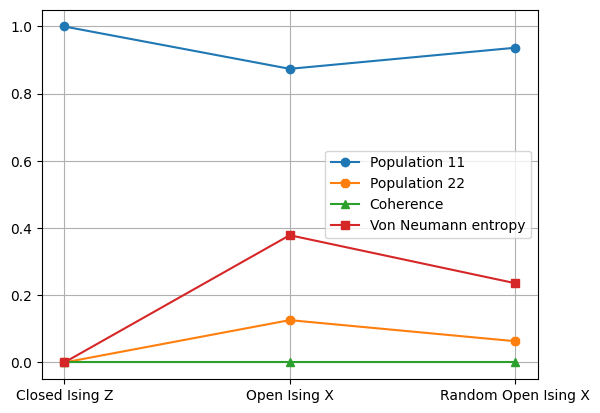

In [15]:
# Computing the density matrix, Von Neumann entropy, entanglement and disorder

x = []
y1 = []
y2 = []
y3 = []
y4 = []

for model in [CIz, OIx, ROIx]:
    x.append(model.name)

    print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

    # Computing the ground state
    model.phi0, model.l0 = ground_state(model.H)

    # convert to 1D array 
    phi0 = np.asarray(model.phi0.T)[0] 
    
    # Computing the density matrix
    rho = avdensmat(phi0, model.N)
    print_latex(r"\rho = " + as_latex_matrix(rho))

    # Computing the Von Neumann entropy
    s = SvN(rho)
    print_latex(r"\text{Von Numann entropy: } S_{vN}(\rho) = " + f"{s:.3f}")

    # Computing the entanglement and disorder
    print_latex(r"\text{Entanglement: } \Epsilon(\phi_0, N) = " + f"{entangl(phi0, model.N):.3f}")
    print_latex(r"\text{Disorder: } D(\phi_0, N) = " + f"{disorder(phi0,model.N):.3f}")

    # Data to plot
    y1.append(rho[0,0])
    y2.append(rho[1,1])
    y3.append(np.abs(rho[0,1]))
    y4.append(s)

plt.plot(x, np.real(y1), marker="o", label="Population 11")
plt.plot(x, np.real(y2), marker="8", label="Population 22")
plt.plot(x, np.real(y3), marker="^", label="Coherence")
plt.plot(x, np.real(y4), marker="s", label="Von Neumann entropy")
plt.legend()
plt.grid()
plt.show()

### 2.3.2 Antiferromagnetic systems

> **TP question:** Compute the ground states of a ferromagnetic Ising- $Z$ open chain of $N=8$ spins (with $w=0$., $J=1$. a.u.) and of an antiferromagnetic Ising-Z open chain of $N=8$ spins (with $w=0$., $J=-1$. a.u.). Compare the ground state of an antiferromagnetic material with the one of a ferromagnetic material. How are the spins organized in the two cases?

In [16]:
# Computing the ground state of ferro and antiferro Ising Z models with 8 spins

ferro_ising_Z_8 = Model("Open Ferromagnetic Ising Z", model=Model.Ising, N=8, w=0, J=[0,0,1], closed=False)
antiferro_ising_Z_8 = Model("Open Antiferromagnetic Ising Z", model=Model.Ising, N=8, w=0, J=[0,0,-1], closed=False)

print_latex(as_latex_matrix(ferro_ising_Z_8.H))
print_latex(as_latex_matrix(antiferro_ising_Z_8.H))


# Computing the ground state
ferro_ising_Z_8.phi0, ferro_ising_Z_8.l0 = ground_state(ferro_ising_Z_8.H)
print_latex(r"\underline{\textbf{For " + ferro_ising_Z_8.name + r" model}}")
print_latex(r"\phi_0 = " + as_latex_matrix(ferro_ising_Z_8.phi0) + r"\quad \lambda_0 = " + f"{np.real(ferro_ising_Z_8.l0):.3f}")

antiferro_ising_Z_8.phi0, antiferro_ising_Z_8.l0 = ground_state(antiferro_ising_Z_8.H)
print_latex(r"\underline{\textbf{For " + antiferro_ising_Z_8.name + r" model}}")
print_latex(r"\phi_0 = " + as_latex_matrix(antiferro_ising_Z_8.phi0) + r"\quad \lambda_0 = " + f"{np.real(antiferro_ising_Z_8.l0):.3f}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 692 iterations


<IPython.core.display.Math object>

C:\Users\vince\AppData\Local\Temp\ipykernel_3840\342291322.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(i) == i:


<IPython.core.display.Math object>

Converged in 692 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

> **TP question:** Compute the ground states of a ferromagnetic Ising- $Z$ closed chain of $N=3$ spins (with $w=0$., $J=1$. a.u.) and of an antiferromagnetic Ising-Z closed chain of $N=3$ spins (with $w=0$., $J=-1$. a.u.). These chains can be interpreted as one cell of triangular lattices. Compare the ground states of these two spin triangles. What is the difference with the case of the open spin chains?

In [17]:
# Computing the ground state of ferro and antiferro Ising Z models with 3 spins

ferro_ising_Z_3 = Model("Open Ferromagnetic Ising Z", model=Model.Ising, N=3, w=0, J=[0,0,1], closed=False)
antiferro_ising_Z_3 = Model("Open Antiferromagnetic Ising Z", model=Model.Ising, N=3, w=0, J=[0,0,-1], closed=False)

print_latex(as_latex_matrix(ferro_ising_Z_3.H))
print_latex(as_latex_matrix(antiferro_ising_Z_3.H))

# Computing the ground state
print_latex(r"\underline{\textbf{For " + ferro_ising_Z_3.name + r" model}}")
ferro_ising_Z_3.phi0, ferro_ising_Z_3.l0 = ground_state(ferro_ising_Z_3.H)
print_latex(r"\phi_0 = " + as_latex_matrix(ferro_ising_Z_3.phi0) + r"\quad \lambda_0 = " + f"{np.real(ferro_ising_Z_3.l0):.3f}")

print_latex(r"\underline{\textbf{For " + antiferro_ising_Z_3.name + r" model}}")
antiferro_ising_Z_3.phi0, antiferro_ising_Z_3.l0 = ground_state(antiferro_ising_Z_3.H)
print_latex(r"\phi_0 = " + as_latex_matrix(antiferro_ising_Z_3.phi0) + r"\quad \lambda_0 = " + f"{np.real(antiferro_ising_Z_3.l0):.3f}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 190 iterations


C:\Users\vince\AppData\Local\Temp\ipykernel_3840\342291322.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(i) == i:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 190 iterations


<IPython.core.display.Math object>

> **TP question:** From your observations and/or personal research in the literature, explain this notion.

# Chapter 3 - Dynamics of lattice spin systems

## 3.1 Studied models

> **TP question:** For each model, build with python the quantum Hamiltonian H as a $2^N \times 2^N$ array.

In [18]:
Open_HeisenbergXXX_7 = Model("Open Heisenberg XXX", model=Model.Heisenberg, N=7, J=[1,1,1], w=0.1, closed=False)
Closed_HeisenbergXXX_7 = Model("Closed Heisenberg XXX", model=Model.Heisenberg, N=7, J=[1,1,1], w=0.1, closed=True)
Inhomogeneous_HeisenbergXXX_7 = Model("Inhomogeneous Heisenberg XXX", model=Model.InhomoHeisenberg, N=7, w=1, closed=False)

models_3_1 = [Open_HeisenbergXXX_7, Closed_HeisenbergXXX_7, Inhomogeneous_HeisenbergXXX_7]

for model in models_3_1:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(as_latex_matrix(model.H))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 3.2 Spectral integrator

> **TP question:** Define a python function corresponding to the spectral integrator with the following requirement:
>
> `def Dyn(H,t,psi0)`
>    - input data
>        - `H`: 2D array corresponding to the quantum Hamiltonian represented in any basis, or 1D array corresponding to the diagonal of the quantum Hamiltonian in its eigenbasis.
>         - `t`: duration of the time propagation (real number).
>        - `psi0`: 1D array corresponding to the initial quantum state represented in the same basis than H.
>    - output\
>        - 1D array corresponding to |ψ(t)〉 = U (t, 0)|ψ0〉 represente in the same basis than H.

In [33]:
def Dyn(H,t,psi0):
    print(type(H), H.shape, type(psi0), psi0.shape)
    return np.exp(-1j*H*t) @ psi0

## 3.3 Dynamics

> **TP question:** For each model (1) to (3) of Sec $3.1$ integrate the Schrödinger equation on the time interval $t \in[0,500]$ a.u. and compute a list of lists:
> $$
> \text { pop }=\left[\left[\left(\rho_k(i \Delta t)\right)_{11} \text { for } k \in\{1,7\}\right] \text { for } i \in\left\{0, N_{\text {time }}\right\}\right],
> $$
> where $N_{\text {time }}=200$ and $\Delta t=\frac{T}{N_{\text {time }}} \cdot \rho_k(t)$ is the reduced density matrix of the $k$-th spin at time $t$, and then $\left(\rho_k(t)\right)_{11}$ is the population of the state $|1\rangle$ for the $k$-th spin at time $t$.
> For each model and for the two above initial conditions plot a density graph of the population of the state $|1\rangle$ with respect to the spins of the chain (abscissae) and to the time (ordinates), with a color gradient associated with the occupation probability of $|1\rangle$ (in $[0,1])$.

In [65]:
print_latex(as_latex_matrix(sigX) + r"\quad" + as_latex_matrix(sigY) + r"\quad" + as_latex_matrix(sigZ) + r"\quad" + as_latex_matrix(sig1))

Open_HeisenbergXXX_3 = Model("Open Heisenberg XXX", model=Model.Heisenberg, N=3, J=[1,1,1], w=0.1, closed=False)
print_latex(as_latex_matrix(Open_HeisenbergXXX_3.H))
Open_HeisenbergXXX_3.H = heisenbergXXX(N=3)
Closed_HeisenbergXXX_3 = Model("Closed Heisenberg XXX", model=Model.Heisenberg, N=3, J=[1,1,1], w=0.1, closed=True)
Inhomogeneous_HeisenbergXXX_3 = Model("Inhomogeneous Heisenberg XXX", model=Model.InhomoHeisenberg, N=3, w=1, closed=False)

models_3_1_test = [Open_HeisenbergXXX_3, Closed_HeisenbergXXX_3, Inhomogeneous_HeisenbergXXX_3]

for model in models_3_1_test:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(as_latex_matrix(model.H))

C:\Users\vince\AppData\Local\Temp\ipykernel_3840\342291322.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(i) == i:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

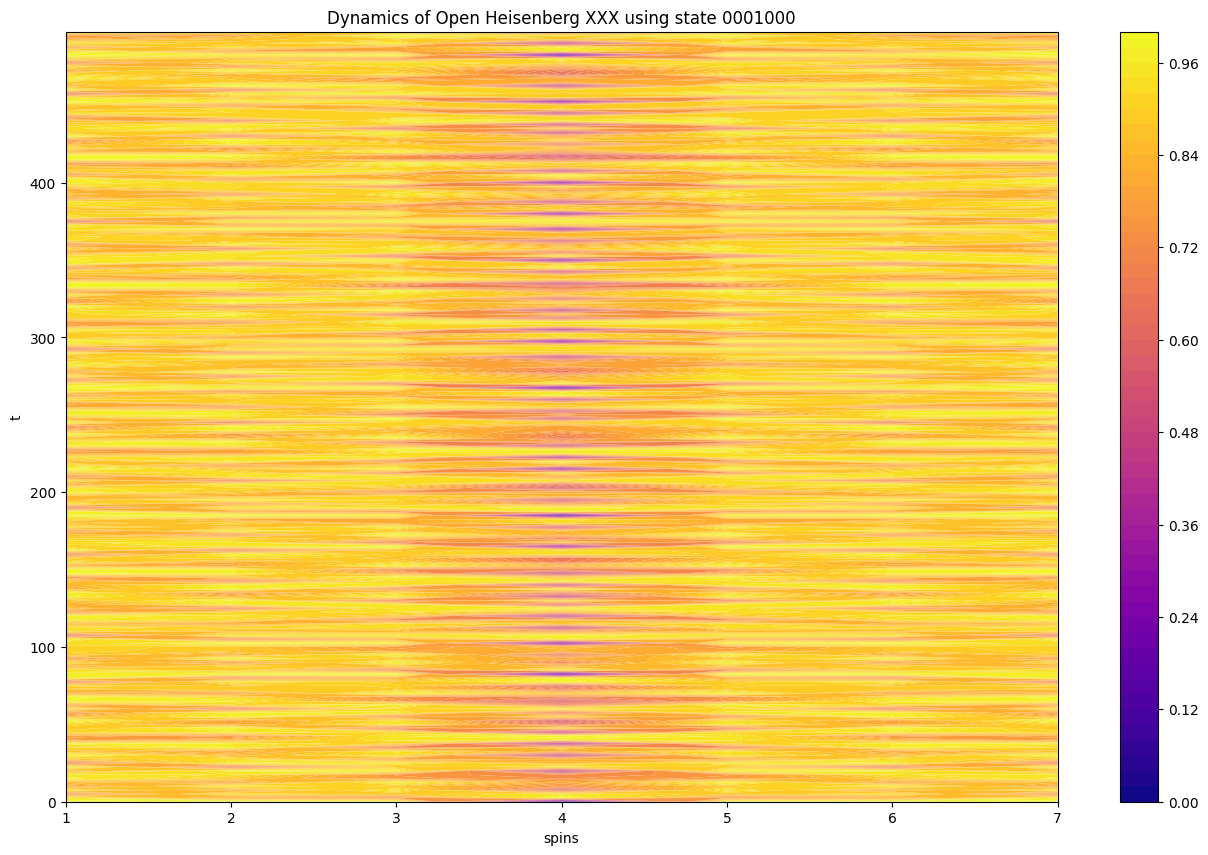

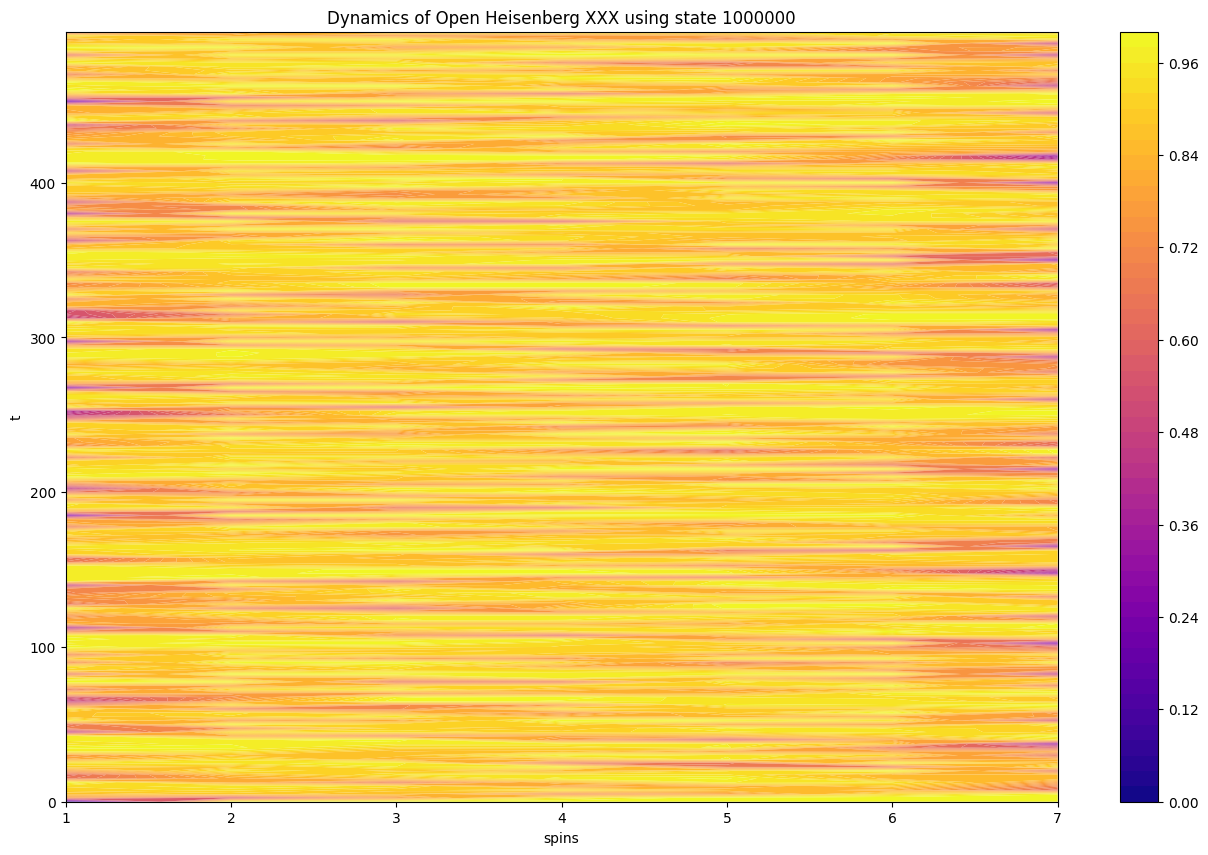

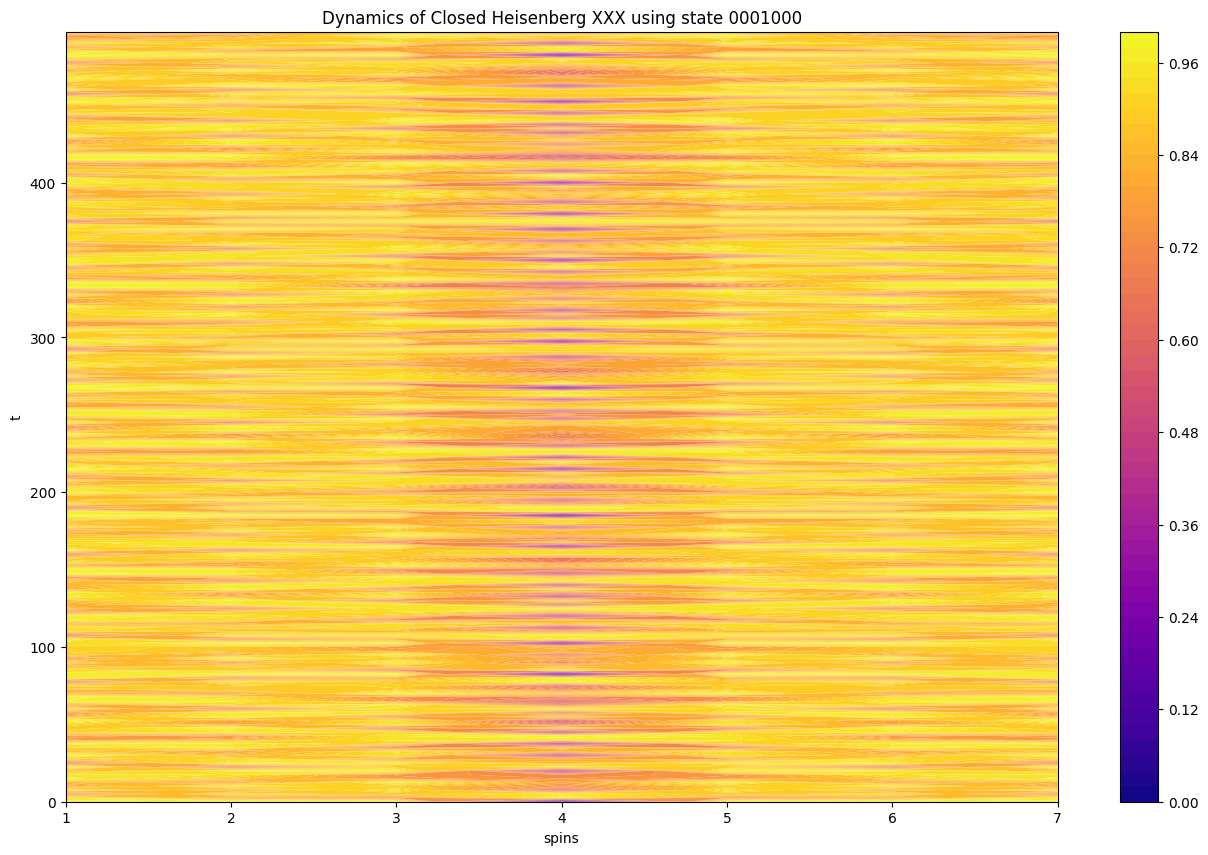

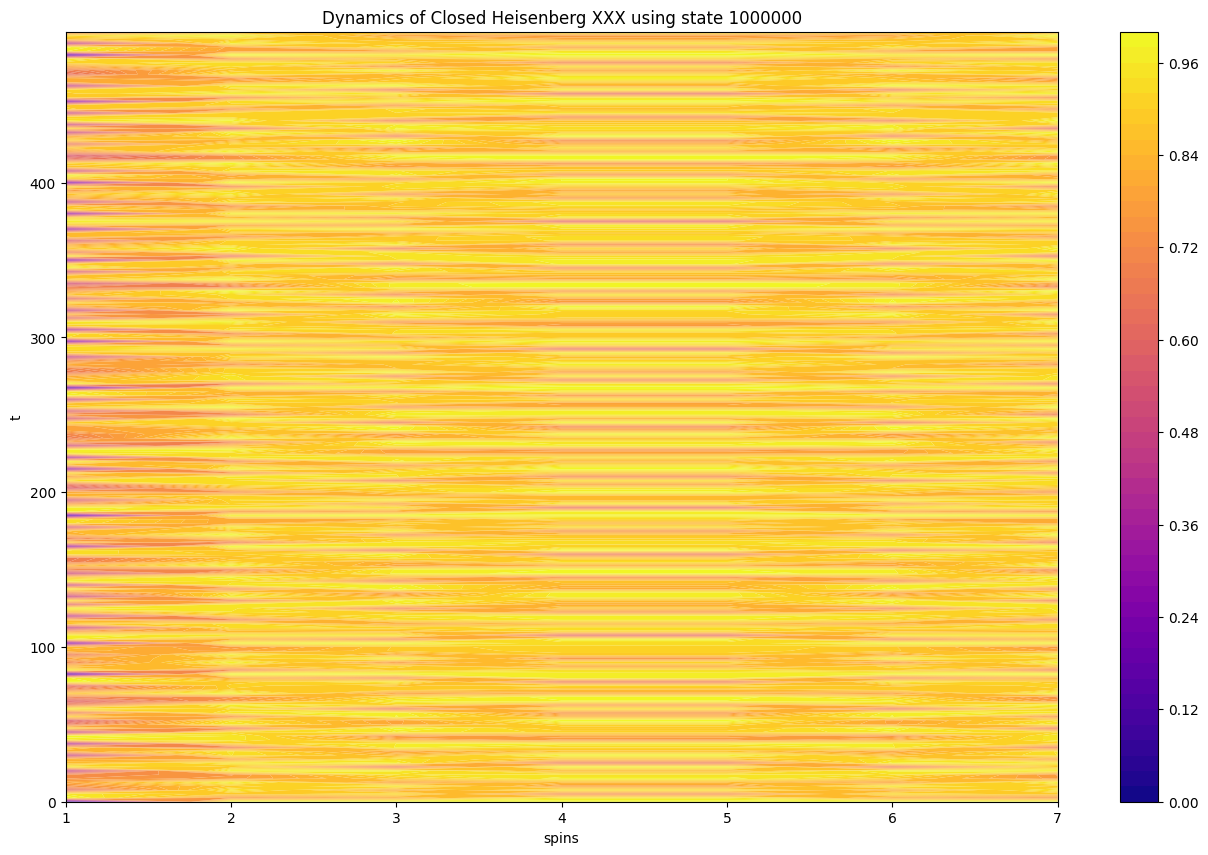

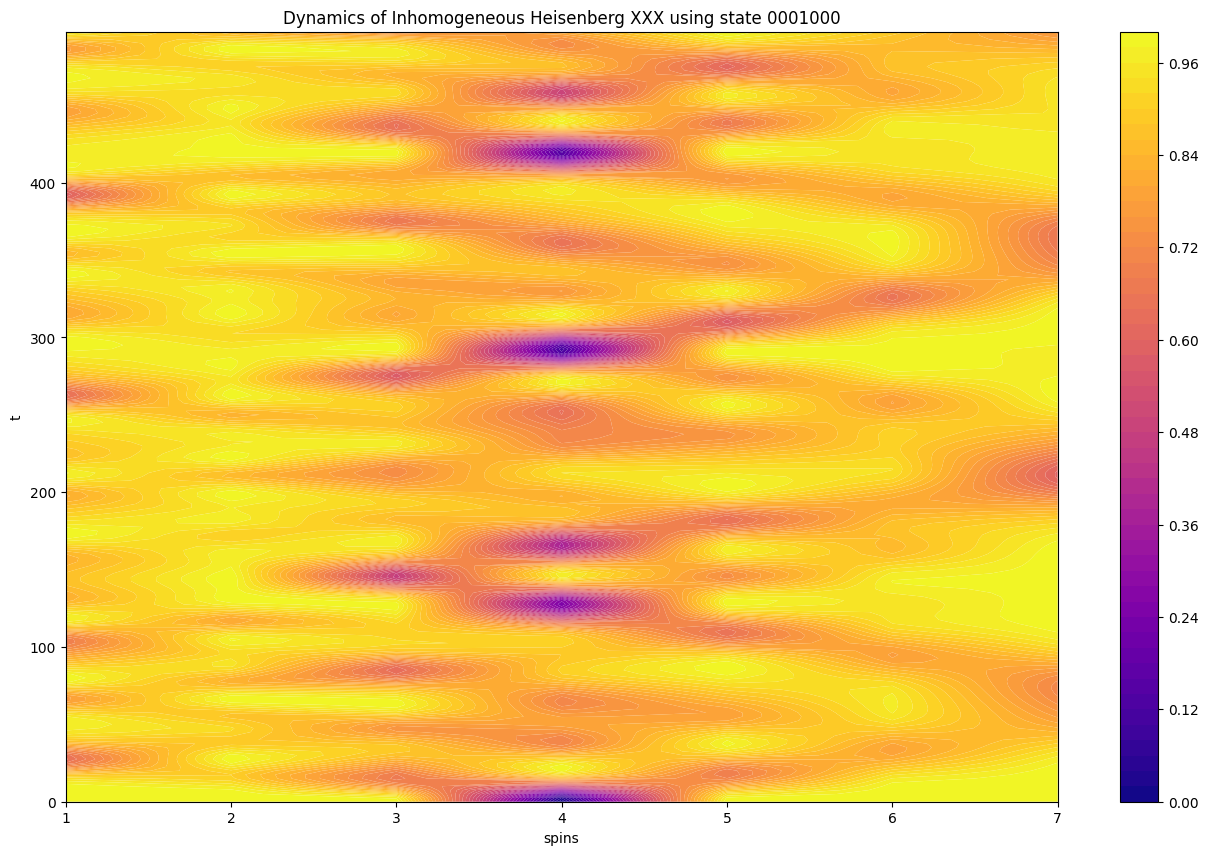

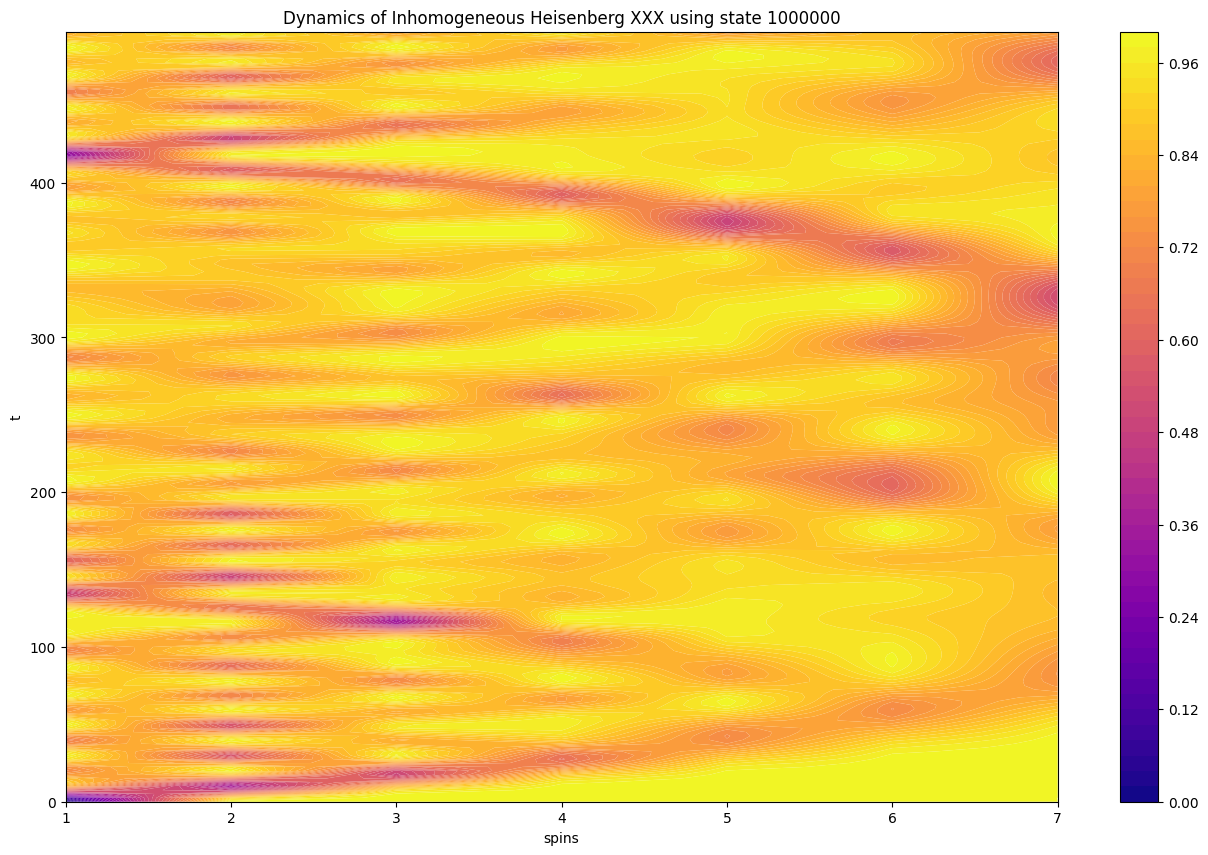

In [54]:
def plot_dynamics2(model, psi0=None):
    if psi0 is None:
        psi0 = ground_state(model.H, verbose=False)[0]
    N_time = 200
    T = 500
    dt = T / N_time

    pop = np.empty((model.N, N_time))

    for t in range(N_time):
        for n in range(model.N):
            psi = Dyn(model.H, t*dt, psi0)
            pop[n, t] = np.real(densmat(as_array(psi), n + 1, model.N))[0, 0]

    plt.figure(figsize=(16, 10))
    plt.pcolor(np.arange(model.N)+1, np.linspace(0,T,N_time,endpoint=True), pop.T, cmap='plasma', antialiased=True)
    plt.xlabel("spins")
    plt.ylabel("t")
    plt.colorbar()
    plt.title("Dynamics of " + model.name)

def evolutionOperator(H, t):
    return LA2.expm(-1j * H * t)


def dynamics(H, t, psi0):
    return np.dot(evolutionOperator(H, t), psi0)


def plot_dynamics(N, H, T, state, name):
    N_time = 200
    dt = T / N_time
    psi0 = buildstate(state)
    pop = np.empty((N, N_time))
    for i in range(N_time):
        for k in range(N):
            psi = dynamics(H, i * dt, psi0)
            pop[k, i] = np.real(densmat(psi, k + 1, N))[0, 0]

    plt.figure(figsize=(16, 10))
    plt.contourf(range(1, N + 1), [i * dt for i in range(N_time)], pop.T, [i * 0.02 for i in range(51)], cmap='plasma', antialiased=True)
    plt.xlabel("spins")
    plt.ylabel("t")
    plt.title("Dynamics of " + name + " using state " + state)
    plt.colorbar()
    plt.show()


# H = np.matrix(np.eye(2**3))
# H[3, 2**3-1] = 10
# H[2**3-1, 3] = 10
# H[4, 2**3-1-5] = 20
# H[2**3-1-5 ,4] = 20
# print(H)
# plot_dynamics(3, H, 500, '010')

for model in models_3_1:
    plot_dynamics(model.N, model.H, 500, '0001000', model.name)
    plot_dynamics(model.N, model.H, 500, '1000000', model.name)
    

> **TP question:** Comment the graphs. Explain the behaviours of the quantum excitation. What is the important difference between open and closed chains? For the model (1) let vary $w$ and J (using also smaller and larger values than the ones used before), to establish how the propagation of a quantum excitation in the spin chain depends on the Larmor frequency and the exchange integral (study in particular the propagation speed of the quantum excitation).

# Chapter 4 - Control of lattice spin systems

## 4.1 Introduction to quantum control

## 4.2 Adiabatic quantum control: quantum annealing

### 4.2.1 Adiabatic quantum control

### 4.2.2 Quantum annealing

> **TP question**: Find ˆxi, the quantum operator equivalent to the classical binary variable xi with respect to
id2 and σiz (ˆxi|0〉 = 0 and ˆxi|1〉 = |1〉). Deduce the values of the Larmor frequencies wi and of the exchange
integrals Jij with respect to the polynomial coefficients ui and eij 

> **TP question:** Define a python function corresponding to a degree 2 polynomial P with 5 variables and
with integer coefficients randomly chosen in {−10, ..., 10}.

> **TP question:** Code a python program classically solving the QUBO problem by testing one by one all 5
digit binary numbers. Build a python function corresponding to t 7 → H(t) (we can choose w0 = 1 a.u.).
Integrate the Schrödinger equation until T = 100 a.u. with |ψ0〉 chosen as the ground state of Hin.

> **TP question:** Verify the adiabatic assumption by computing at each time step |〈φ0(t)|ψ(t)〉|2, where |φ0(t)〉
is the ground state of H(t), and draw the graph representing this quantity (the adiabatic tracking probability)
with respect to t.

> **TP question:** Return the Dirac representation of |ψ(T )〉 in the binary basis.

> **TP question:** Compare the solution of the QUBO problem found with the classical algorithm with |ψ(T )〉
and comment. Let T vary in order to find the minimal time for which the adiabatic assumption seems valid